# Detekcija pšenice (Global Wheat Detection)


**Opis zadatka:**

Riječ je o temi natjecanja [Global Wheat Detection na Kaggleu](https://www.kaggle.com/competitions/global-wheat-detection): cilj je detektirati klasove pšenice (wheat heads) na snimkama polja. U bilježnici se obrađuju: metrike evaluacije detekcije (IoU, preciznost, odziv), učenje osjetljivo na cijenu, stabla odluke i inženjering značajki kao baseline, te YOLO za stvarnu detekciju (unaprijed trenirani model i fino ugađanje na označenim podacima). Na kraju se uspoređuju početno i završno treniranje modela.

**Izvor podataka i literatura:**

Podaci dolaze s natjecanja [Global Wheat Detection (Kaggle)](https://www.kaggle.com/competitions/global-wheat-detection/data). Skup sadrži slike u formatu JPG i YOLO-format oznaka (jedna .txt datoteka po slici).

**Struktura skupa i glavne varijable:**

U direktoriju `data/` nalaze se:
- `train/` – slike za treniranje (`.jpg`)
- `labels/` – oznake u YOLO formatu (`.txt`): svaki red jedan objekt, stupci `class_id cx cy w h` (normalizirano 0–1). Koristimo samo jednu klasu (wheat head). Za svaku sliku očekuje se odgovarajuća label datoteka s istim imenom (npr. `slika.jpg` ↔ `slika.txt`).

**Instalacija potrebnih paketa:**

In [2]:
%pip install -q ultralytics opencv-python scikit-learn scikit-image pandas numpy matplotlib torch


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


**Uključivanje potrebnih paketa:**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
from ultralytics import YOLO
import torch
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('data')
TRAIN_DIR = DATA_DIR / 'train'
LABELS_DIR = DATA_DIR / 'labels'


### Priprema i čišćenje podataka

In [4]:
n_images = len(list(TRAIN_DIR.glob('*.jpg')))
n_labels = len(list(LABELS_DIR.glob('*.txt')))
img_stems = {p.stem for p in TRAIN_DIR.glob('*.jpg')}
label_stems = {p.stem for p in LABELS_DIR.glob('*.txt')}
match = img_stems == label_stems and n_images == n_labels
print(n_images, n_labels, match)

3422 3422 True


**Odluku donesena tijekom čišćenja podataka:**

Provjerom broja slika i broja labela te usporedbom imena (jedan label po slici) utvrdili smo da broj labela odgovara broju slika i da svaka slika ima odgovarajuću oznaku; odluka je da su podaci već čisti i da nije potrebno uklanjati ili ispravljati primjerke.

## 1. Metrike evaluacije

Uvodimo mjere za usporedbu predviđenih okvira s pravim oznakama (IoU, preciznost, odziv, F1). Potrebne su nam kako bi znali koliko dobro model detektira klasove pšenice.


In [5]:
def iou(box1, box2):
    x1_1 = box1[0] - box1[2] / 2
    y1_1 = box1[1] - box1[3] / 2
    x2_1 = box1[0] + box1[2] / 2
    y2_1 = box1[1] + box1[3] / 2
    
    x1_2 = box2[0] - box2[2] / 2
    y1_2 = box2[1] - box2[3] / 2
    x2_2 = box2[0] + box2[2] / 2
    y2_2 = box2[1] + box2[3] / 2
    
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i < x1_i or y2_i < y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0


In [6]:
def match_boxes(pred_boxes, gt_boxes, iou_thresh=0.5):
    matches = []
    unmatched_pred = list(range(len(pred_boxes)))
    unmatched_gt = list(range(len(gt_boxes)))
    
    iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
    for i, p in enumerate(pred_boxes):
        for j, g in enumerate(gt_boxes):
            iou_matrix[i, j] = iou(p, g)
    
    while True:
        if not unmatched_pred or not unmatched_gt:
            break
        best_iou = 0
        best_p, best_g = None, None
        for p_idx in unmatched_pred:
            for g_idx in unmatched_gt:
                if iou_matrix[p_idx, g_idx] > best_iou:
                    best_iou = iou_matrix[p_idx, g_idx]
                    best_p, best_g = p_idx, g_idx
        if best_iou >= iou_thresh:
            matches.append((best_p, best_g))
            unmatched_pred.remove(best_p)
            unmatched_gt.remove(best_g)
        else:
            break
    
    return len(matches), len(unmatched_pred), len(unmatched_gt)


In [7]:
def load_yolo_label(path):
    boxes = []
    if path.exists():
        with open(path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    boxes.append([float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])
    return boxes

image_files = list(TRAIN_DIR.glob('*.jpg'))[:20]
images = []
labels = []

for img_path in image_files:
    img = cv2.imread(str(img_path))
    if img is not None:
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        label_path = LABELS_DIR / f"{img_path.stem}.txt"
        labels.append(load_yolo_label(label_path))


In [8]:
np.random.seed(42)
preds = []
for gt in labels[:10]:
    pred = []
    for box in gt:
        if np.random.random() > 0.1:
            noise = np.random.normal(0, 0.05, 4)
            noisy = [max(0, min(1, box[i] + noise[i])) for i in range(4)]
            noisy[0] = max(noisy[2]/2, min(1 - noisy[2]/2, noisy[0]))
            noisy[1] = max(noisy[3]/2, min(1 - noisy[3]/2, noisy[1]))
            pred.append(noisy)
    for _ in range(len(gt) // 2):
        pred.append([np.random.uniform(0.1, 0.9), np.random.uniform(0.1, 0.9), 
                     np.random.uniform(0.05, 0.15), np.random.uniform(0.05, 0.15)])
    preds.append(pred)

tp_total = fp_total = fn_total = 0
for pred, gt in zip(preds, labels[:10]):
    tp, fp, fn = match_boxes(pred, gt)
    tp_total += tp
    fp_total += fp
    fn_total += fn

precision = tp_total / (tp_total + fp_total + 1e-10)
recall = tp_total / (tp_total + fn_total + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"Preciznost: {precision:.4f}")
print(f"Odziv: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"TP: {tp_total}, FP: {fp_total}, FN: {fn_total}")


Preciznost: 0.0362
Odziv: 0.0500
F1-Score: 0.0420
TP: 18, FP: 479, FN: 342


## 2. Evaluacija praga

Za različite pragove pouzdanosti računamo preciznost, odziv i cijenu (propust detekcije košta više od lažne detekcije). Time biramo prag koji je u praksi najkorisniji.


0.1


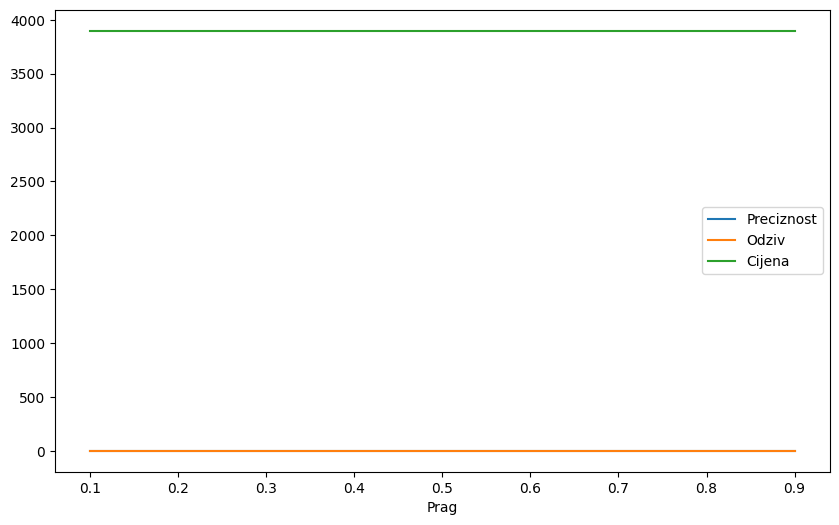

In [9]:
def evaluate_threshold(preds, gts, conf_thresh, iou_thresh=0.5):
    filtered = []
    for p in preds:
        filtered.append([box for box in p if len(box) < 5 or box[4] >= conf_thresh])
    
    tp = fp = fn = 0
    for f, gt in zip(filtered, gts):
        t, fa, fn_val = match_boxes(f, gt, iou_thresh)
        tp += t
        fp += fa
        fn += fn_val
    
    prec = tp / (tp + fp + 1e-10)
    rec = tp / (tp + fn + 1e-10)
    cost = fn * 10 + fp * 1
    return prec, rec, cost

thresholds = np.arange(0.1, 1.0, 0.1)
results = []
for thresh in thresholds:
    prec, rec, cost = evaluate_threshold(preds, labels[:10], thresh)
    results.append({'threshold': thresh, 'precision': prec, 'recall': rec, 'cost': cost})

df_results = pd.DataFrame(results)
opt_idx = df_results['cost'].idxmin()
print(df_results.loc[opt_idx, 'threshold'])

plt.figure(figsize=(10, 6))
plt.plot(df_results['threshold'], df_results['precision'], label='Preciznost')
plt.plot(df_results['threshold'], df_results['recall'], label='Odziv')
plt.plot(df_results['threshold'], df_results['cost'], label='Cijena')
plt.xlabel('Prag')
plt.legend()
plt.show()


## 3. Stablo odluke

Iz slika izvlačimo jednostavne značajke (boja, rubovi, tekstura) i stablon odluke predviđamo sadrži li slika pšenicu.


In [10]:
def extract_features(img):
    features = {}
    features['mean_r'] = np.mean(img[:, :, 0])
    features['mean_g'] = np.mean(img[:, :, 1])
    features['mean_b'] = np.mean(img[:, :, 2])
    features['std_r'] = np.std(img[:, :, 0])
    features['std_g'] = np.std(img[:, :, 1])
    features['std_b'] = np.std(img[:, :, 2])
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    features['edge_density'] = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    
    try:
        glcm = graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
        features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
        features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    except:
        features['contrast'] = 0
        features['homogeneity'] = 0
    
    return features

X = pd.DataFrame([extract_features(img) for img in images])
y = np.array([1 if len(l) > 0 else 0 for l in labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



## 4. Inženjering značajki

Dodajemo napredniju značajku (prosjek boja u sredini slike) i odabirom značajki (RFE) ostavljamo samo one najvažnije. Time smanjujemo šum i poboljšavamo mogućnost učenja.

In [11]:
def extract_advanced_features(img):
    feat = extract_features(img)
    h, w = img.shape[:2]
    center = img[h//4:3*h//4, w//4:3*w//4]
    feat['center_mean_r'] = np.mean(center[:, :, 0])
    feat['center_mean_g'] = np.mean(center[:, :, 1])
    feat['center_mean_b'] = np.mean(center[:, :, 2])
    return feat

X_advanced = pd.DataFrame([extract_advanced_features(img) for img in images])
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_advanced, y)

selected = X_advanced.columns[rfe.support_].tolist()
print(selected)


['mean_b', 'std_r', 'std_g', 'std_b', 'edge_density', 'contrast', 'homogeneity', 'center_mean_r', 'center_mean_g', 'center_mean_b']


## 5. YOLO detekcija (unaprijed trenirani model – ne detektira pšenicu, samo usporedba modela)

Unaprijed trenirani YOLO modeli trenirani su na COCO skupu (80 klasa: ptice, auti, ljudi), ali ne i klasovi pšenice. Neće detektirati pšenicu. Ovaj odlomak samo uspoređuje brzinu i veličinu modela. Za stvarnu detekciju pšenice vidi odlomak 6 (fino ugađanje).


Nano - prosječno vrijeme: 0.061s, ukupno detekcija: 0
Medium - prosječno vrijeme: 0.188s, ukupno detekcija: 2
Napomena: Ove detekcije su iz COCO klasa (ptice, ljudi itd.), ne klasovi pšenice.
Za detekciju pšenice potrebno je fino ugađanje (odlomak 6).


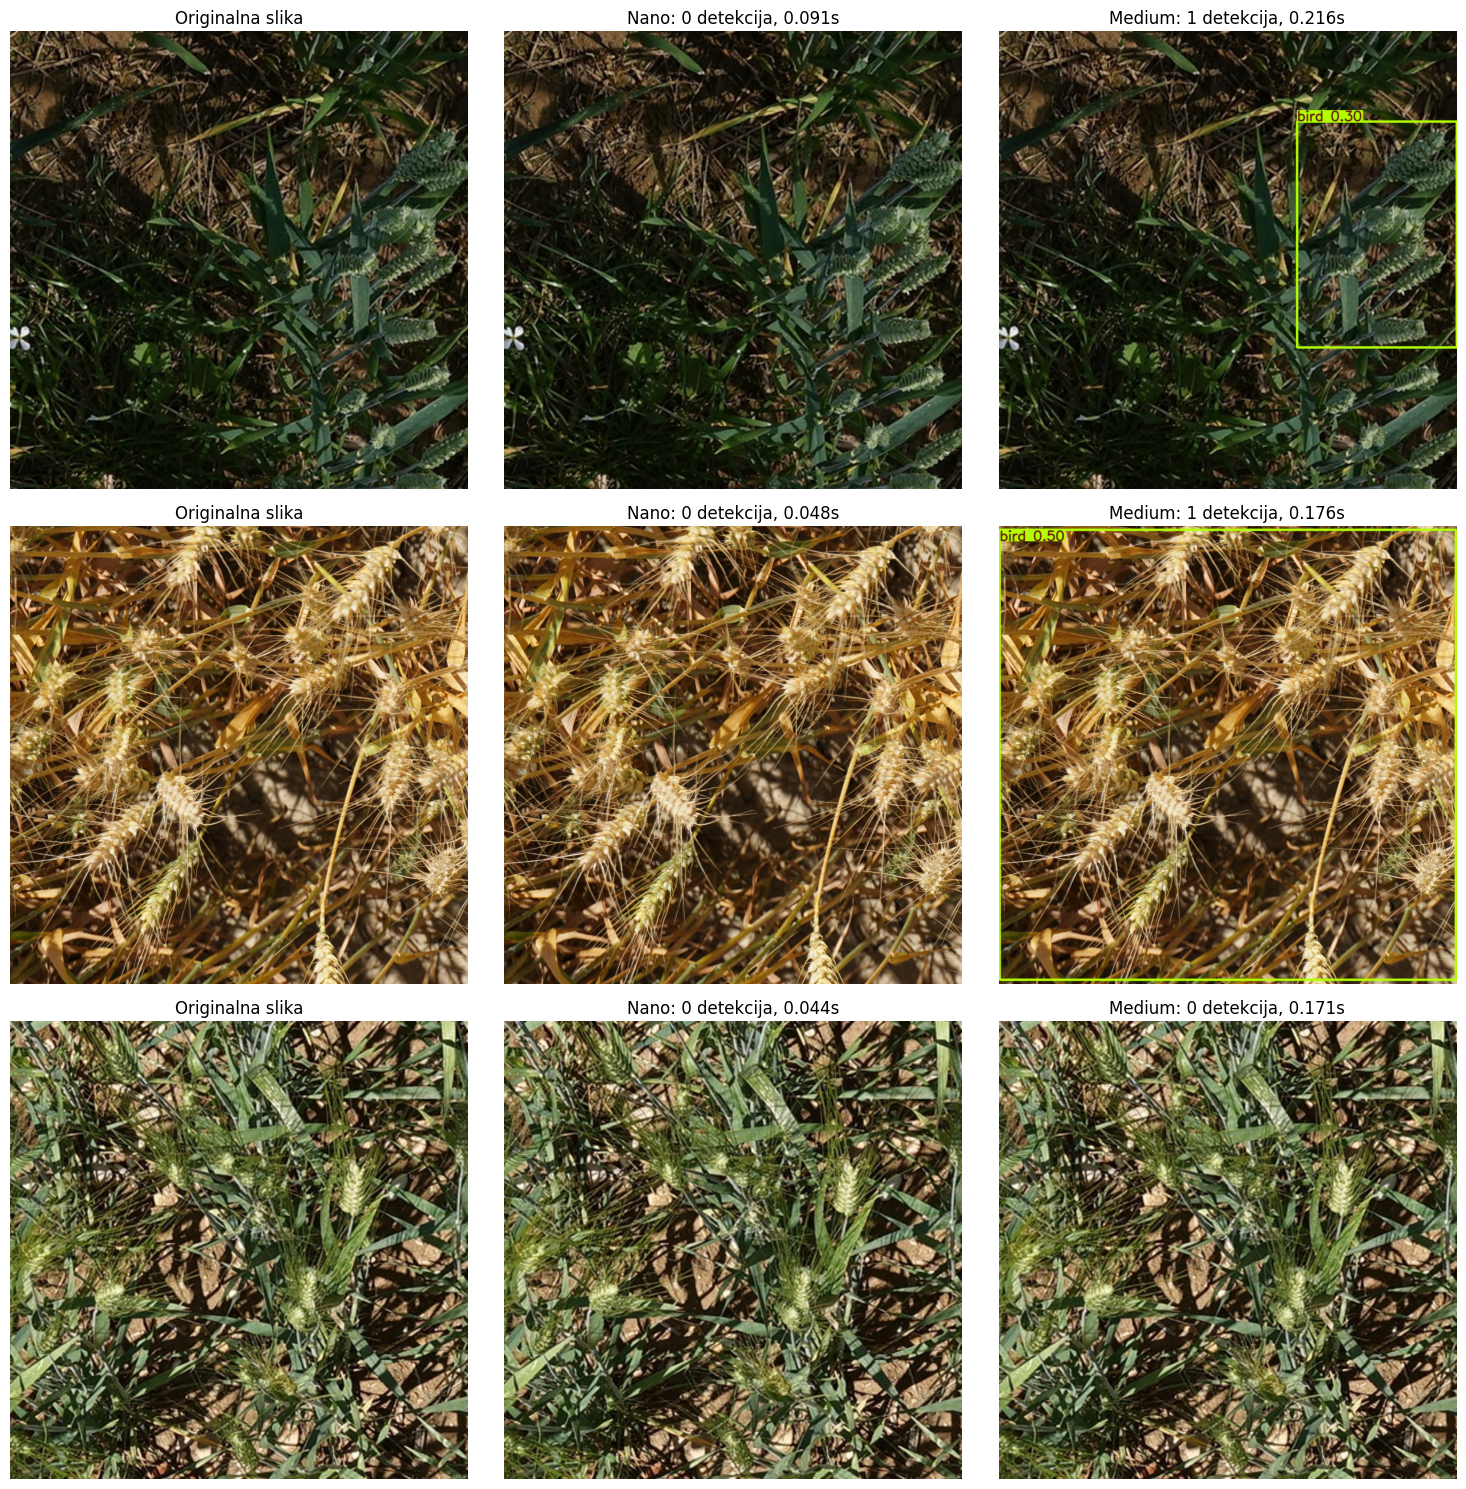

In [12]:
import time

model_nano = YOLO('yolo11n.pt')
model_medium = YOLO('yolo11m.pt')

test_imgs = images[:3]
times_nano = []
times_medium = []
detections_nano = []
detections_medium = []

for img in test_imgs:
    start = time.time()
    result_nano = model_nano(img, conf=0.25, verbose=False)[0]
    times_nano.append(time.time() - start)
    detections_nano.append(len(result_nano.boxes))
    
    start = time.time()
    result_medium = model_medium(img, conf=0.25, verbose=False)[0]
    times_medium.append(time.time() - start)
    detections_medium.append(len(result_medium.boxes))

print(f"Nano - prosječno vrijeme: {np.mean(times_nano):.3f}s, ukupno detekcija: {sum(detections_nano)}")
print(f"Medium - prosječno vrijeme: {np.mean(times_medium):.3f}s, ukupno detekcija: {sum(detections_medium)}")
print("Napomena: Ove detekcije su iz COCO klasa (ptice, ljudi itd.), ne klasovi pšenice.")
print("Za detekciju pšenice potrebno je fino ugađanje (odlomak 6).")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    axes[i, 0].imshow(test_imgs[i])
    axes[i, 0].set_title('Originalna slika')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(model_nano(test_imgs[i], conf=0.25, verbose=False)[0].plot())
    axes[i, 1].set_title(f'Nano: {detections_nano[i]} detekcija, {times_nano[i]:.3f}s')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(model_medium(test_imgs[i], conf=0.25, verbose=False)[0].plot())
    axes[i, 2].set_title(f'Medium: {detections_medium[i]} detekcija, {times_medium[i]:.3f}s')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


## 6. YOLO fino ugađanje


In [13]:
import shutil

image_files = list(TRAIN_DIR.glob('*.jpg'))
np.random.seed(42)
np.random.shuffle(image_files)

n_train = int(len(image_files) * 0.7)
n_val = int(len(image_files) * 0.15)

train_files = image_files[:n_train]
val_files = image_files[n_train:n_train+n_val]
test_files = image_files[n_train+n_val:]

dataset_dir = Path('wheat_dataset')
for split in ['train', 'val', 'test']:
    (dataset_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (dataset_dir / split / 'labels').mkdir(parents=True, exist_ok=True)

for img_path in train_files:
    shutil.copy(img_path, dataset_dir / 'train' / 'images' / img_path.name)
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, dataset_dir / 'train' / 'labels' / label_path.name)

for img_path in val_files:
    shutil.copy(img_path, dataset_dir / 'val' / 'images' / img_path.name)
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, dataset_dir / 'val' / 'labels' / label_path.name)

for img_path in test_files:
    shutil.copy(img_path, dataset_dir / 'test' / 'images' / img_path.name)
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, dataset_dir / 'test' / 'labels' / label_path.name)

yaml_content = f"""path: {dataset_dir.absolute()}
train: train/images
val: val/images
test: test/images
nc: 1
names:
  0: wheat_head
"""

with open(dataset_dir / 'data.yaml', 'w') as f:
    f.write(yaml_content)


### Konfiguracija treniranja

Postavljamo flaggove za pokretanje treniranja. Treniranje će se preskočiti ako model već postoji.


In [14]:
# Zastavice konfiguracije treniranja
# Postavi True za pokretanje treniranja, False za preskakanje
# Treniranje će se automatski preskočiti ako model već postoji
TRAIN_INITIAL = False  # Prvo treniranje (POC: 5 epoha, imgsz=320, batch=128)
TRAIN_FINAL = False    # Drugo treniranje (puno: 50 epoha, imgsz=640, batch=16)

# Putanje modela
INITIAL_MODEL_PATH = Path("runs/detect/train/weights/best.pt")
FINAL_MODEL_PATH = Path("runs/detect/train2/weights/best.pt")


In [15]:
# Prvo treniranje (POC – brzi test)
if TRAIN_INITIAL and not INITIAL_MODEL_PATH.exists():
    import os
    import torch

    # Set environment for maximum MPS performance
    os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

    device = 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu'
    workers = 4  # macOS multiprocessing limitation - 4-8 is usually max
    batch_size = 128 if device == 'mps' else 64  # Increased for faster training
    imgsz = 320  # Smaller = faster (was 512, can use 320 for even faster POC)

    print("="*80)
    print("POKRETANJE POČETNOG TRENIRANJA (POC)")
    print("="*80)
    print(f"Uređaj: {device}")
    print(f"Workeri: {workers}")
    print(f"Veličina serije: {batch_size}")
    print(f"Veličina slike: {imgsz}")
    print()

    model = YOLO('yolo11n.pt')

    results = model.train(
    data=str(dataset_dir / 'data.yaml'),
    epochs=5,  # Fewer epochs for POC
    imgsz=imgsz,
    batch=batch_size,
    patience=3,  # Lower patience for POC
    device=device,
    workers=workers,
    amp=True,  # CRITICAL: Enable mixed precision for ~2x speedup
    cache='disk',  # Faster than RAM cache with 0 workers
    plots=False,
    save_period=5,
    close_mosaic=0,  # Disable mosaic closing (saves time)
    val=False,  # Already disabled - good!
    
    # Disable expensive augmentations for speed
    mosaic=0.0,  # Disable mosaic augmentation
    mixup=0.0,   # Disable mixup
    copy_paste=0.0,  # Disable copy-paste
    degrees=0.0,  # Disable rotation
    translate=0.0,  # Disable translation
    scale=0.0,  # Disable scaling
    fliplr=0.0,  # Disable horizontal flip
    hsv_h=0.0,  # Disable HSV augmentation
    hsv_s=0.0,
    hsv_v=0.0,
    
    # Other speed optimizations
    verbose=False,  # Less logging overhead
    deterministic=False,  # Slightly faster without determinism
    )
    
    metrics = model.val()
    print(f"\nZavršne metrike:")
    print(f"mAP@50: {metrics.box.map50:.4f}")
    print(f"mAP@50-95: {metrics.box.map:.4f}")
    print(f"Preciznost: {metrics.box.mp:.4f}")
    print(f"Odziv: {metrics.box.mr:.4f}")
    
    print("\n" + "="*80)
    print("POČETNO TRENIRANJE ZAVRŠENO")
    print("="*80)
elif INITIAL_MODEL_PATH.exists():
    print(f"✓ Početni model već postoji na {INITIAL_MODEL_PATH}")
    print("  Preskačem početno treniranje. Postavi TRAIN_INITIAL=True i obriši model za ponovno treniranje.")
else:
    print("⚠️  Početno treniranje je isključeno (TRAIN_INITIAL=False)")
    print("  Postavi TRAIN_INITIAL=True za uključivanje treniranja.")


✓ Početni model već postoji na runs/detect/train/weights/best.pt
  Preskačem početno treniranje. Postavi TRAIN_INITIAL=True i obriši model za ponovno treniranje.


In [16]:
# Drugo treniranje (puno – produkcijska kvaliteta)
if TRAIN_FINAL and not FINAL_MODEL_PATH.exists():
    print("\n" + "="*80)
    print("POKRETANJE ZAVRŠNOG TRENIRANJA (puno)")
    print("="*80)
    print("Konfiguracija: 50 epoha, imgsz=640, batch=16, pune augmentacije")
    print()
    
    model = YOLO('yolo11n.pt')

    results = model.train(
        data=str(dataset_dir / 'data.yaml'),
        epochs=50,
        imgsz=640,
        batch=16,
        patience=20
    )
    
    print("\n" + "="*80)
    print("ZAVRŠNO TRENIRANJE ZAVRŠENO")
    print("="*80)
elif FINAL_MODEL_PATH.exists():
    print(f"\n✓ Završni model već postoji na {FINAL_MODEL_PATH}")
    print("  Preskačem završno treniranje. Postavi TRAIN_FINAL=True i obriši model za ponovno treniranje.")
else:
    print("\n⚠️  Završno treniranje je isključeno (TRAIN_FINAL=False)")
    print("  Postavi TRAIN_FINAL=True za uključivanje treniranja.")



⚠️  Završno treniranje je isključeno (TRAIN_FINAL=False)
  Postavi TRAIN_FINAL=True za uključivanje treniranja.


## 7. Primjer korištenja – inferencija s treniranim modelom


In [17]:
# Učitaj najbolji trenirani model (automatski odabire dostupan model)
from pathlib import Path

# Provjeri koji modeli postoje (prednost završni/train2, zatim početni/train)
final_model_path = Path("runs/detect/train2/weights/best.pt")
initial_model_path = Path("runs/detect/train/weights/best.pt")

if final_model_path.exists():
    best_model_path = str(final_model_path)
    model_name = "Završni (train2)"
elif initial_model_path.exists():
    best_model_path = str(initial_model_path)
    model_name = "Početni (train)"
else:
    raise FileNotFoundError(
        "Nije pronađen trenirani model! Prvo pokreni treniranje.\n"
        f"  Očekivane lokacije:\n"
        f"    - {final_model_path}\n"
        f"    - {initial_model_path}\n"
        f"  Postavi TRAIN_INITIAL=True ili TRAIN_FINAL=True i pokreni ćelije za treniranje."
    )

trained_model = YOLO(best_model_path)
print(f"✓ Učitano: model {model_name} s: {best_model_path}")

# Pokreni inferenciju na nekoliko testnih slika
test_images = list((dataset_dir / 'test' / 'images').glob('*.jpg'))[:3]  # Prve 3 testne slike

for img_path in test_images:
    # Pokreni predikciju
    results = trained_model(str(img_path))
    
    # Vizualiziraj rezultate
    results[0].show()
    
    # Ispiši podatke o detekcijama
    print(f"\nSlika: {img_path.name}")
    print(f"Detekcije: {len(results[0].boxes)}")
    
    if len(results[0].boxes) > 0:
        for i, box in enumerate(results[0].boxes[:5]):  # Prvih 5 detekcija
            conf = float(box.conf[0])
            bbox = box.xyxy[0].tolist()
            print(f"  Detekcija {i+1}: pouzdanost={conf:.3f}, bbox={[round(x, 1) for x in bbox]}")
    else:
        print("  Nema detekcija")
    print("-" * 50)


✓ Učitano: model Početni (train) s: runs/detect/train/weights/best.pt

image 1/1 /Users/drazenbaric/Projects/upz-pdp/wheat_dataset/test/images/a7436f5c7.jpg: 320x320 15 wheat_heads, 12.5ms
Speed: 0.6ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)

Slika: a7436f5c7.jpg
Detekcije: 15
  Detekcija 1: pouzdanost=0.712, bbox=[318.9, 545.5, 435.5, 670.2]
  Detekcija 2: pouzdanost=0.562, bbox=[55.5, 295.4, 154.5, 394.5]
  Detekcija 3: pouzdanost=0.542, bbox=[203.1, 311.5, 286.4, 415.1]
  Detekcija 4: pouzdanost=0.532, bbox=[202.5, 433.8, 291.4, 551.7]
  Detekcija 5: pouzdanost=0.496, bbox=[807.0, 322.7, 895.4, 427.0]
--------------------------------------------------

image 1/1 /Users/drazenbaric/Projects/upz-pdp/wheat_dataset/test/images/6895c563e.jpg: 320x320 37 wheat_heads, 16.7ms
Speed: 0.9ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)

Slika: 6895c563e.jpg
Detekcije: 37
  Detekcija 1: pouzdanost=0.826, bbox=[41

## 8. Usporedba: početno i završno treniranje


⚠️ Završni model (train2) nije pronađen. Preskačem usporedbu – prikazujem samo metrike početnog modela.
   (Možeš preskočiti drugo treniranje, ali rezultati će biti lošije kvalitete)

Učitavanje početnog modela (train)...
Evaluacija početnog modela...
Ultralytics 8.3.235 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2042.6±1443.8 MB/s, size: 165.0 KB)
val: Scanning /Users/drazenbaric/Projects/upz-pdp/wheat_dataset/val/labels.cache... 513 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 513/513 2.4Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 1.3it/s 26.0s0.7ss
                   all        513      21356      0.833      0.687      0.757      0.343
Speed: 0.1ms preprocess, 41.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /Users/drazenbaric/Projects/

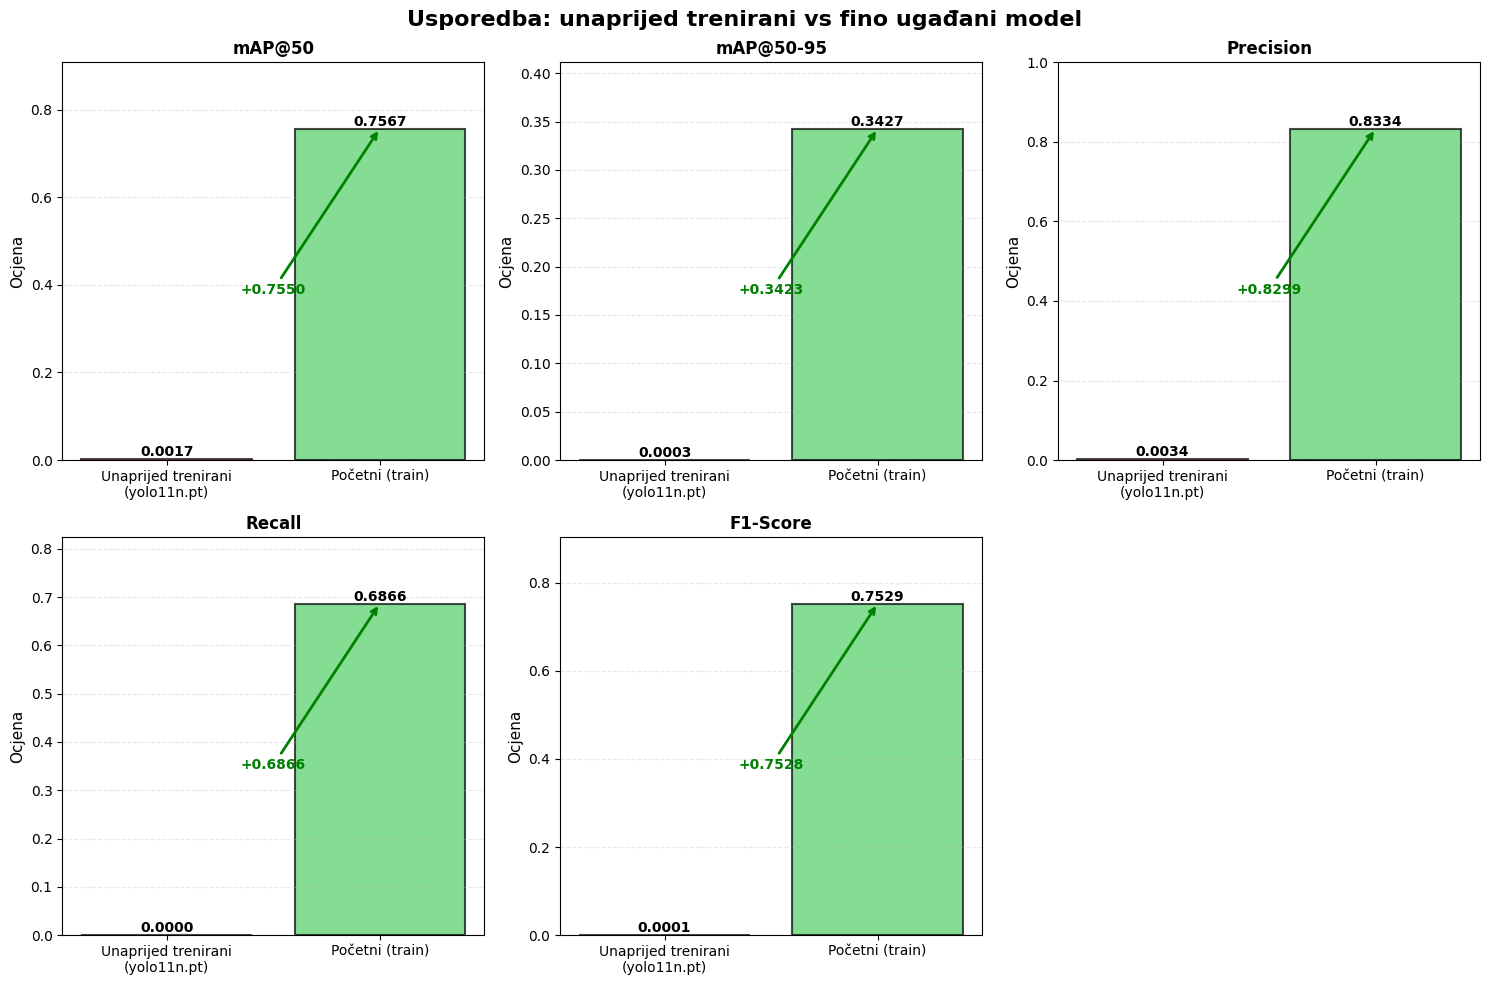


SAŽETAK UTJECAJA FINO UGAĐANJA
Unaprijed trenirani model: yolo11n.pt (COCO skup – 80 klasa, NIJE treniran na pšenici)
Fino ugađani model: Početni (train) (treniran na skupu za detekciju pšenice)

Ključna poboljšanja od fino ugađanja:
  ✓ Precision: +0.8299 (+24233.9% relativno)
  ✓ mAP@50: +0.7550 (+43976.5% relativno)
  ✓ F1-Score: +0.7528 (+814828.5% relativno)
  ✓ Recall: +0.6866 (+1466200.0% relativno)
  ✓ mAP@50-95: +0.3423 (+99703.6% relativno)


In [18]:
# Učitaj modele (provjeri postoje li oba)
initial_model_path = "runs/detect/train/weights/best.pt"
final_model_path = "runs/detect/train2/weights/best.pt"

from pathlib import Path

initial_exists = Path(initial_model_path).exists()
final_exists = Path(final_model_path).exists()

if not initial_exists and not final_exists:
    print("⚠️ Nije pronađen nijedan trenirani model. Prvo pokreni treniranje.")
elif not initial_exists:
    print("⚠️ Početni model (train) nije pronađen. Dostupan je samo završni model.")
elif not final_exists:
    print("⚠️ Završni model (train2) nije pronađen. Preskačem usporedbu – prikazujem samo metrike početnog modela.")
    print("   (Možeš preskočiti drugo treniranje, ali rezultati će biti lošije kvalitete)")
else:
    print("✓ Oba modela pronađena. Pokrećem usporedbu...")

# Učitaj i evaluiraj početni model
if initial_exists:
    print("\nUčitavanje početnog modela (train)...")
    initial_model = YOLO(initial_model_path)
    print("Evaluacija početnog modela...")
    initial_metrics = initial_model.val(data=str(dataset_dir / 'data.yaml'))

# Učitaj i evaluiraj završni model (ako postoji)
if final_exists:
    print("\nUčitavanje završnog modela (train2)...")
    final_model = YOLO(final_model_path)
    print("Evaluacija završnog modela...")
    final_metrics = final_model.val(data=str(dataset_dir / 'data.yaml'))

# Izvuci metrike
if initial_exists:
    initial_map50 = initial_metrics.box.map50
    initial_map = initial_metrics.box.map
    initial_precision = initial_metrics.box.mp
    initial_recall = initial_metrics.box.mr
    initial_f1 = 2 * (initial_precision * initial_recall) / (initial_precision + initial_recall + 1e-10)

if final_exists:
    final_map50 = final_metrics.box.map50
    final_map = final_metrics.box.map
    final_precision = final_metrics.box.mp
    final_recall = final_metrics.box.mr
    final_f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall + 1e-10)

# Evaluiraj i unaprijed trenirani model (prije fino ugađanja) za usporedbu
pretrained_model_path = "yolo11n.pt"
pretrained_exists = Path(pretrained_model_path).exists()

if pretrained_exists:
    print("\nEvaluacija unaprijed treniranog modela (prije fino ugađanja)...")
    pretrained_model = YOLO(pretrained_model_path)
    pretrained_metrics = pretrained_model.val(data=str(dataset_dir / 'data.yaml'))
    
    pretrained_map50 = pretrained_metrics.box.map50
    pretrained_map = pretrained_metrics.box.map
    pretrained_precision = pretrained_metrics.box.mp
    pretrained_recall = pretrained_metrics.box.mr
    pretrained_f1 = 2 * (pretrained_precision * pretrained_recall) / (pretrained_precision + pretrained_recall + 1e-10)

# Prikaži usporedbu samo ako oba modela postoje
if not (initial_exists and final_exists):
    if initial_exists:
        print("\n" + "="*80)
        print("METRIKE POČETNOG MODELA (train)")
        print("="*80)
        print(f"mAP@50:     {initial_map50:.4f}")
        print(f"mAP@50-95:  {initial_map:.4f}")
        print(f"Preciznost: {initial_precision:.4f}")
        print(f"Odziv:      {initial_recall:.4f}")
        print("="*80)
        print("\nNapomena: Ovo je POC treniranje (5 epoha, imgsz=320).")
        print("      Za bolje rezultate pokreni drugo treniranje (50 epoha, imgsz=640).")
    elif final_exists:
        print("\n" + "="*80)
        print("METRIKE ZAVRŠNOG MODELA (train2)")
        print("="*80)
        print(f"mAP@50:     {final_map50:.4f}")
        print(f"mAP@50-95:  {final_map:.4f}")
        print(f"Preciznost: {final_precision:.4f}")
        print(f"Odziv:      {final_recall:.4f}")
        print("="*80)

# Usporedba unaprijed treniranog i fino ugađanog modela (ako postoje)
if pretrained_exists and (initial_exists or final_exists):
    print("\n" + "="*80)
    print("USPOREDBA: UNAPRIJED TRENIRANI vs FINO UGAĐANI MODEL")
    print("="*80)
    
    # Koristi završni model ako postoji, inače početni
    if final_exists:
        fine_tuned_map50 = final_map50
        fine_tuned_map = final_map
        fine_tuned_precision = final_precision
        fine_tuned_recall = final_recall
        fine_tuned_f1 = final_f1
        model_name = "Završni (train2)"
    else:
        fine_tuned_map50 = initial_map50
        fine_tuned_map = initial_map
        fine_tuned_precision = initial_precision
        fine_tuned_recall = initial_recall
        fine_tuned_f1 = initial_f1
        model_name = "Početni (train)"
    
    pretuned_comparison = {
        'Metrika': ['mAP@50', 'mAP@50-95', 'Preciznost', 'Odziv', 'F1-Score'],
        'Unaprijed trenirani (yolo11n.pt)': [
            f'{pretrained_map50:.4f}',
            f'{pretrained_map:.4f}',
            f'{pretrained_precision:.4f}',
            f'{pretrained_recall:.4f}',
            f'{pretrained_f1:.4f}'
        ],
        f'{model_name}': [
            f'{fine_tuned_map50:.4f}',
            f'{fine_tuned_map:.4f}',
            f'{fine_tuned_precision:.4f}',
            f'{fine_tuned_recall:.4f}',
            f'{fine_tuned_f1:.4f}'
        ],
        'Poboljšanje': [
            f'{fine_tuned_map50 - pretrained_map50:+.4f}',
            f'{fine_tuned_map - pretrained_map:+.4f}',
            f'{fine_tuned_precision - pretrained_precision:+.4f}',
            f'{fine_tuned_recall - pretrained_recall:+.4f}',
            f'{fine_tuned_f1 - pretrained_f1:+.4f}'
        ],
        'Poboljšanje %': [
            f'{((fine_tuned_map50 - pretrained_map50) / pretrained_map50 * 100):+.2f}%' if pretrained_map50 > 0 else 'N/A',
            f'{((fine_tuned_map - pretrained_map) / pretrained_map * 100):+.2f}%' if pretrained_map > 0 else 'N/A',
            f'{((fine_tuned_precision - pretrained_precision) / pretrained_precision * 100):+.2f}%' if pretrained_precision > 0 else 'N/A',
            f'{((fine_tuned_recall - pretrained_recall) / pretrained_recall * 100):+.2f}%' if pretrained_recall > 0 else 'N/A',
            f'{((fine_tuned_f1 - pretrained_f1) / pretrained_f1 * 100):+.2f}%' if pretrained_f1 > 0 else 'N/A'
        ]
    }
    
    pretuned_df = pd.DataFrame(pretuned_comparison)
    print(pretuned_df.to_string(index=False))
    print("="*80)
    
    # Vizualizacija unaprijed treniranog vs fino ugađanog
    fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
    fig2.suptitle('Usporedba: unaprijed trenirani vs fino ugađani model', fontsize=16, fontweight='bold')
    
    metrics_pt = ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score']
    pretrained_values = [pretrained_map50, pretrained_map, pretrained_precision, pretrained_recall, pretrained_f1]
    finetuned_values = [fine_tuned_map50, fine_tuned_map, fine_tuned_precision, fine_tuned_recall, fine_tuned_f1]
    
    for idx, metric in enumerate(metrics_pt):
        ax = axes2.flat[idx]
        x = ['Unaprijed trenirani\n(yolo11n.pt)', f'{model_name}']
        y = [pretrained_values[idx], finetuned_values[idx]]
        colors = ['#ff6b6b', '#51cf66']
        
        bars = ax.bar(x, y, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Ocjena', fontsize=11)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_ylim([0, max(y) * 1.2])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Oznake vrijednosti na stupcima
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Strelica poboljšanja
        improvement = finetuned_values[idx] - pretrained_values[idx]
        if improvement != 0:
            arrow_color = 'green' if improvement > 0 else 'red'
            ax.annotate(f'{improvement:+.4f}',
                       xy=(1, finetuned_values[idx]),
                       xytext=(0.5, (pretrained_values[idx] + finetuned_values[idx])/2),
                       arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2),
                       fontsize=10, fontweight='bold', color=arrow_color,
                       ha='center')
    
    # Sakrij 6. podgraf (imamo samo 5 metrika)
    axes2.flat[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("SAŽETAK UTJECAJA FINO UGAĐANJA")
    print("="*80)
    print(f"Unaprijed trenirani model: yolo11n.pt (COCO skup – 80 klasa, NIJE treniran na pšenici)")
    print(f"Fino ugađani model: {model_name} (treniran na skupu za detekciju pšenice)")
    print("\nKljučna poboljšanja od fino ugađanja:")
    pt_improvements = {
        'mAP@50': fine_tuned_map50 - pretrained_map50,
        'mAP@50-95': fine_tuned_map - pretrained_map,
        'Precision': fine_tuned_precision - pretrained_precision,
        'Recall': fine_tuned_recall - pretrained_recall,
        'F1-Score': fine_tuned_f1 - pretrained_f1
    }
    pt_initial_vals = {'mAP@50': pretrained_map50, 'mAP@50-95': pretrained_map, 'Precision': pretrained_precision, 'Recall': pretrained_recall, 'F1-Score': pretrained_f1}
    
    for metric, improvement in sorted(pt_improvements.items(), key=lambda x: abs(x[1]), reverse=True):
        if improvement > 0:
            rel_improvement = (improvement / pt_initial_vals[metric] * 100) if pt_initial_vals[metric] > 0 else 0
            print(f"  ✓ {metric}: +{improvement:.4f} (+{rel_improvement:.1f}% relativno)")
        elif improvement < 0:
            rel_change = (improvement / pt_initial_vals[metric] * 100) if pt_initial_vals[metric] > 0 else 0
            print(f"  ✗ {metric}: {improvement:.4f} ({rel_change:.1f}% relativno)")
        else:
            print(f"  = {metric}: bez promjene")
    print("="*80)

if initial_exists and final_exists:
    # Oba modela postoje – prikaži usporedbu
    # Tablica usporedbe
    comparison_data = {
    'Metrika': ['mAP@50', 'mAP@50-95', 'Preciznost', 'Odziv', 'F1-Score'],
    'Početni (train)': [
        f'{initial_map50:.4f}',
        f'{initial_map:.4f}',
        f'{initial_precision:.4f}',
        f'{initial_recall:.4f}',
        f'{initial_f1:.4f}'
    ],
    'Završni (train2)': [
        f'{final_map50:.4f}',
        f'{final_map:.4f}',
        f'{final_precision:.4f}',
        f'{final_recall:.4f}',
        f'{final_f1:.4f}'
    ],
    'Poboljšanje': [
        f'{final_map50 - initial_map50:+.4f}',
        f'{final_map - initial_map:+.4f}',
        f'{final_precision - initial_precision:+.4f}',
        f'{final_recall - initial_recall:+.4f}',
        f'{final_f1 - initial_f1:+.4f}'
    ],
    'Poboljšanje %': [
        f'{((final_map50 - initial_map50) / initial_map50 * 100):+.2f}%' if initial_map50 > 0 else 'N/A',
        f'{((final_map - initial_map) / initial_map * 100):+.2f}%' if initial_map > 0 else 'N/A',
        f'{((final_precision - initial_precision) / initial_precision * 100):+.2f}%' if initial_precision > 0 else 'N/A',
        f'{((final_recall - initial_recall) / initial_recall * 100):+.2f}%' if initial_recall > 0 else 'N/A',
        f'{((final_f1 - initial_f1) / initial_f1 * 100):+.2f}%' if initial_f1 > 0 else 'N/A'
    ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("USPOREDBA MODELA: početno i završno treniranje")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Usporedba modela: početno i završno treniranje', fontsize=16, fontweight='bold')
    
    metrics = ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score']
    initial_values = [initial_map50, initial_map, initial_precision, initial_recall, initial_f1]
    final_values = [final_map50, final_map, final_precision, final_recall, final_f1]
    
    for idx, metric in enumerate(metrics):
        ax = axes.flat[idx]
        x = ['Početni\n(train)', 'Završni\n(train2)']
        y = [initial_values[idx], final_values[idx]]
        colors = ['#ff6b6b', '#51cf66']
        
        bars = ax.bar(x, y, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Ocjena', fontsize=11)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_ylim([0, max(y) * 1.2])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Oznake vrijednosti na stupcima
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Strelica poboljšanja
        improvement = final_values[idx] - initial_values[idx]
        if improvement != 0:
            arrow_color = 'green' if improvement > 0 else 'red'
            ax.annotate(f'{improvement:+.4f}',
                       xy=(1, final_values[idx]),
                       xytext=(0.5, (initial_values[idx] + final_values[idx])/2),
                       arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2),
                       fontsize=10, fontweight='bold', color=arrow_color,
                       ha='center')
    
    # Sakrij 6. podgraf (imamo samo 5 metrika)
    axes.flat[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Sažetak
    print("\n" + "="*80)
    print("SAŽETAK")
    print("="*80)
    print(f"Početno treniranje: 5 epoha, imgsz=320, batch=128, minimalne augmentacije")
    print(f"Završno treniranje: 50 epoha, imgsz=640, batch=16, pune augmentacije")
    print("\nKljučna poboljšanja:")
    improvements = {
        'mAP@50': final_map50 - initial_map50,
        'mAP@50-95': final_map - initial_map,
        'Precision': final_precision - initial_precision,
        'Recall': final_recall - initial_recall,
        'F1-Score': final_f1 - initial_f1
    }
    # Calculate relative improvements
    initial_vals = {'mAP@50': initial_map50, 'mAP@50-95': initial_map, 'Precision': initial_precision, 'Recall': initial_recall, 'F1-Score': initial_f1}
    
    for metric, improvement in sorted(improvements.items(), key=lambda x: abs(x[1]), reverse=True):
        if improvement > 0:
            rel_improvement = (improvement / initial_vals[metric] * 100) if initial_vals[metric] > 0 else 0
            print(f"  ✓ {metric}: +{improvement:.4f} (+{rel_improvement:.1f}% relativno)")
        elif improvement < 0:
            rel_change = (improvement / initial_vals[metric] * 100) if initial_vals[metric] > 0 else 0
            print(f"  ✗ {metric}: {improvement:.4f} ({rel_change:.1f}% relativno, zahtijeva pažnju)")
        else:
            print(f"  = {metric}: bez promjene")
    print("="*80)


## 9. Statistička hipoteza

In [19]:
from scipy import stats

def count_objects(label_dir):
    counts = []
    for p in Path(label_dir).glob('*.txt'):
        with open(p) as f:
            n = sum(1 for _ in f)
        counts.append(n)
    return np.array(counts)

train_counts = count_objects(dataset_dir / 'train' / 'labels')
val_counts = count_objects(dataset_dir / 'val' / 'labels')
stat, p = stats.mannwhitneyu(train_counts, val_counts, alternative='two-sided')
print('Mann-Whitney U:', stat, 'p-vrijednost:', p)
print('Medijana (train):', np.median(train_counts), 'Medijana (val):', np.median(val_counts))

Mann-Whitney U: 646720.5 p-vrijednost: 0.060420018026021566
Medijana (train): 43.0 Medijana (val): 41.0


**Hipoteza:**

Nul hipoteza H₀: medijana broja detekcija (wheat heads) po slici u train skupu jednaka je medijani u val skupu. 

Alternativa: medijane se razlikuju.


**Test.**

Korišten je Mann–Whitney U test (dvostrani). Broj detekcija po slici nije nužno normalno distribuirana i skupovi su nezavisni, pa parametarski t-test nije primjeren; Mann–Whitney je neparametarski i ne zahtijeva normalnost.

**Pretpostavke.**

(1) Uzorci su nezavisni (različite slike u train i val).

(2) Varijabla je barem ordinalna (broj detekcija).

(3) Oblik distribucije u oba skupa je sličan (za interpretaciju razlike u lokaciji). Te su pretpostavke zadovoljene.

**Rezultati.**

Mann–Whitney U = 646720,5; p-vrijednost = 0,0604. Medijana (train): 43,0; medijana (val): 41,0.

**Interpretacija.**

Budući da je p ≈ 0,0604 ≥ 0,05, H₀ ne odbacujemo: nemamo dovoljno dokaza za statistički značajnu razliku u broju wheat heads po slici između train i val skupa. Podjela na train/val u skladu je s jednakom raspodjelom broja detekcija po slici.